# 10. 그리드 서치
- 무엇을 최적화해야 할지 알았으면 이제 파라미터를 최적화하는 방법에 대한 문제를 해결할 차례

In [2]:
library(tidyverse)
library(tidymodels)
tidymodels_prefer()

library(ggforce)
library(av)
library(lme4)
data(cells)
theme_set(theme_bw())

<br>

## 10.01. 정규 및 비정규 그리드
- 그리드에는 두 가지 주요 유형이 존재 : 
    - **정규 그리드는 각 파라미터(해당 가능한 값 세트와)를 요인적으로 결합. 즉, 집합의 모든 조합을 사용**
    - **비정규 그리드는 작은 점 집합으로 구성되지 않는 그리드**

<br>

#### 신경망 예시
- 튜닝 가능한 파라미터
    1. 은닉층
    2. 모델 훈련의 적합 에포크
        - 에포크 수는 조기 중지에 의해 결정

    3. 가중치 감소 페널티 크기

<br>

- 모델 정의
    - `trace = 0` : 학습 프로세스의 추가 로깅 방지

In [4]:
mlp_spec <- mlp(hidden_units = tune(), penalty = tune(), epochs = tune()) %>%
    set_engine("nnet", trace = 0) %>%
    set_mode("classification")

In [5]:
mlp_param <- extract_parameter_set_dials(mlp_spec)
mlp_param %>% print

Collection of 3 parameters for tuning

   identifier         type    object
 hidden_units hidden_units nparam[+]
      penalty      penalty nparam[+]
       epochs       epochs nparam[+]



In [9]:
mlp_param %>% extract_parameter_dials("hidden_units") 

# Hidden Units (quantitative)
Range: [1, 10]

In [8]:
mlp_param %>% extract_parameter_dials("penalty")

Amount of Regularization (quantitative)
Transformer: log-10 [1e-100, Inf]
Range (transformed scale): [-10, 0]

In [10]:
mlp_param %>% extract_parameter_dials("epochs")

# Epochs (quantitative)
Range: [10, 1000]

<br>

### 정규 그리드
- 정규 그리드는 개별 파라미터 값 세트의 조합

#### ```crossing()```

In [11]:
crossing(hidden_units = 1:3,
         penalty = c(0.0, 0.1),
         epochs = c(100, 200)) 

hidden_units,penalty,epochs
<int>,<dbl>,<dbl>
1,0.0,100
1,0.0,200
1,0.1,100
1,0.1,200
2,0.0,100
2,0.0,200
2,0.1,100
2,0.1,200
3,0.0,100


<br>

#### ```grid0_regular()```
- `levels` : 파라미터당 level 수

<br>

- 은닉층 `hidden_units` 파라미터 범위를 3개
    
    에포크 `epochs` 파라미터 범위를 2개
    
    가중치 감소 페널티 `penalty` 파라미터 범위를 2개

In [15]:
grid_regular(mlp_param, levels = c(hidden_units = 3, penalty = 2, epochs = 2)) 

hidden_units,penalty,epochs
<int>,<dbl>,<int>
1,1e-10,10
5,1e-10,10
10,1e-10,10
1,1e+00,10
5,1e+00,10
10,1e+00,10
1,1e-10,1000
5,1e-10,1000
10,1e-10,1000


<br>

- 정규 그리드는 계산 비용이 많이 들 수도 있음
- **정규 그리드의 장점은 튜닝 파라미터와 모델 성능간 관계와 패턴을 쉽게 이해할 수 있다는 것**

<br>

### 비정규 그리드
- 비정규 그리드는 각 파라미터 범위에 걸쳐 무작위 샘플링을 사용 
    - ```grid_random()``` : 파라미터 범위에 걸쳐 독립적인 균일한 난수를 생성
    - 파라미터에 관련된 변환(예: 패널티에 대한 변환)이 있는 경우 변환된 척도에서 난수가 생성

<br>

#### 랜덤 그리드
#### ```grid_random()```

In [16]:
set.seed(1301) 
mlp_param %>% grid_random(size = 1000) %>% summary

  hidden_units       penalty              epochs     
 Min.   : 1.000   Min.   :0.0000000   Min.   : 10.0  
 1st Qu.: 3.000   1st Qu.:0.0000000   1st Qu.:265.8  
 Median : 5.000   Median :0.0000061   Median :497.0  
 Mean   : 5.381   Mean   :0.0437435   Mean   :509.5  
 3rd Qu.: 8.000   3rd Qu.:0.0026854   3rd Qu.:761.0  
 Max.   :10.000   Max.   :0.9814405   Max.   :999.0  

- 랜덤 그리드의 문제는 **파라미터 조합을 겹치게 할 수 있다는 것**. 
- 랜덤 그리드는 전체 파라미터 공간을 커버해야 하지만, 그리드 값의 수에 따라 커버리지가 잘 될 가능성이 증가



<br>

- 무작위로 생성된 15개의 포인트를 가진 3개의 튜닝 파라미터
(```original = FALSE``` : penalty를 log10 단위로 유지)


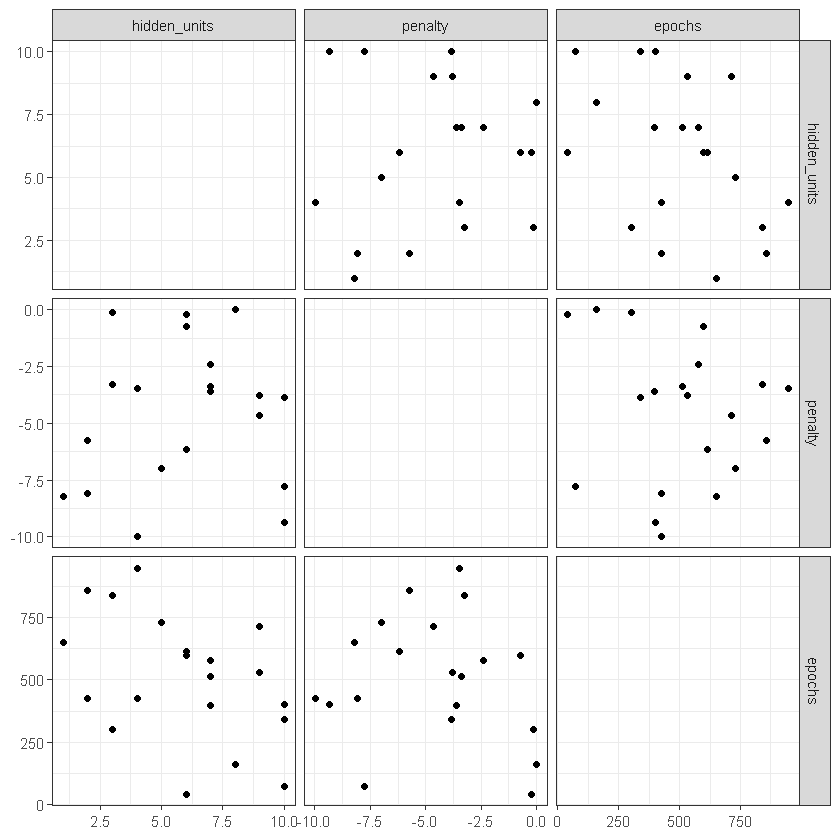

In [19]:
set.seed(1302)
mlp_param %>% grid_random(size = 20, original = FALSE) %>% 
    ggplot(aes(x = .panel_x, y = .panel_y)) + 
    geom_point() +
    geom_blank() +
    facet_matrix(vars(hidden_units, penalty, epochs), layer.diag = 2) 

<br>

#### 공간 채우기 디자인 (Space Filling)
- 디자인 방법마다 목표가 조금씩 다르지만, 일반적으로 값이 중복될 가능성이 가장 적은 매개변수 공간을 포괄하는 점 구성을 탐색
    - 라틴 하이퍼큐브, 최대 엔트로피 디자인, 최대 투영 디자인 등
    - **라틴 하이퍼큐브는 점들을 서로 더 멀리 띄우고 하이퍼 파라미터 공간에 대한 더 나은 탐색을 가능하게 함**
    - **최대 엔트로피 디자인은, 공간을 잘 커버하는 그리드를 생산하는 경향이 있고, 좋은 결과를 탐색할 가능성을 증가시킴**

- **'공간 채우기 설계'는 모수 공간을 표현하는 데 매우 효과적**


<br>

#### ```grid_latin_hypercube()``` : 라틴 하이퍼큐브
#### ```grid_max_entropy()``` : 최대 엔트로피 디자인

<br>

#### 20개의 후보 파라미터 라틴 하이퍼큐브

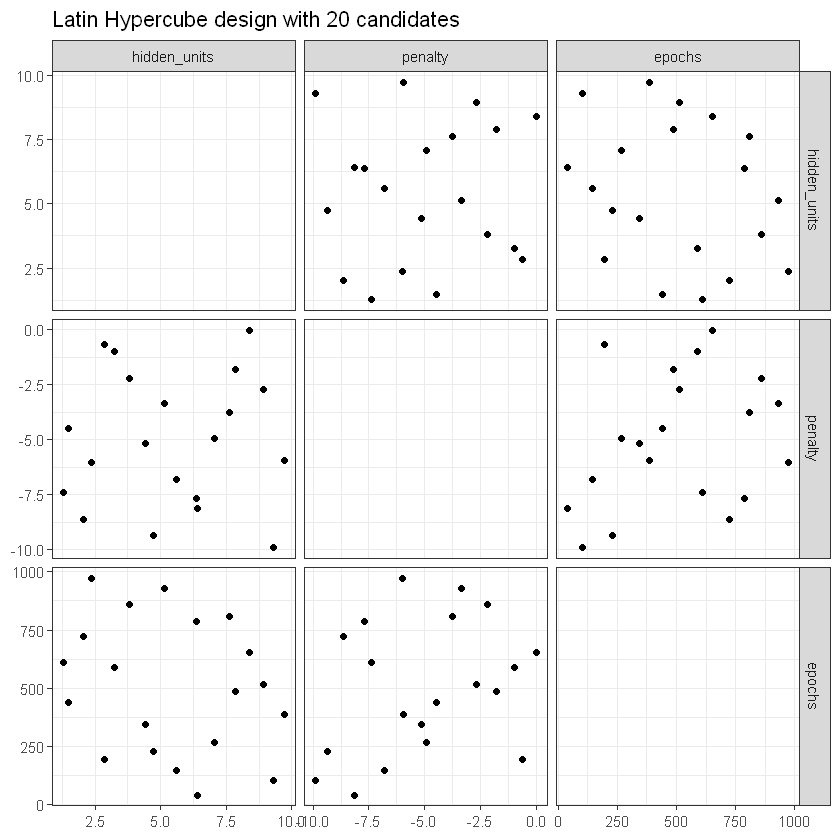

In [20]:
set.seed(1303)
mlp_param %>% grid_latin_hypercube(size = 20, original = FALSE) %>% 
    ggplot(aes(x = .panel_x, y = .panel_y)) + 
    geom_point() +
    geom_blank() +
    facet_matrix(vars(hidden_units, penalty, epochs), layer.diag = 2) + 
    labs(title = "Latin Hypercube design with 20 candidates")

<br>

## 10.02. 그리드 평가
- 최적의 파라미터 조합을 선택하기 위해 각 후보 집합은 해당 모형을 훈련하는 데 사용되지 않은 데이터를 사용하여 평가. 
- 리샘플링 방법 또는 단일 검증 집합은 이 목적에 적합

- 리샘플링 후, 가장 적합한 후보 파라미터 세트를 선택. 경험적으로 최상의 모수 조합을 선택하거나 단순성과 같은 모델 적합의 다른 측면으로 선택을 편향시키는 것이 타당





In [33]:
cells %>%  select(-case) -> cells

- 10-fold 교차검증 세트

In [35]:
set.seed(1304)
cell_folds <- vfold_cv(cells)

- 예측 변수 간의 상관 관계가 높기에, PCA 기능 추출을 사용하여 예측 변수의 관계를 재정립
- **PCA는 분산 기반이므로, 설명변수별 분산에 대한 이상치는 계산에 악영향을 미칠 수 있음**.
    - 이에 각 예측 변수에 대한 Yeo-Johnson 변환을 추정하는 레시피 단계를 추가
    - ```step_YeoJohnson()```은 초기 정규화 직전에 적용
    

<br>

- 전처리 정의

In [22]:
mlp_rec <- recipe(class ~ ., data = cells) %>%
    step_YeoJohnson(all_numeric_predictors()) %>% 
    step_normalize(all_numeric_predictors()) %>% 
    step_pca(all_numeric_predictors(), num_comp = tune()) %>% # 주성분 수에 대한 튜닝 파라미터 지정
    step_normalize(all_numeric_predictors())


- 워크플로 정의

In [23]:
mlp_wflow <- workflow() %>% 
    add_model(mlp_spec) %>% 
    add_recipe(mlp_rec)

- 전체 워크플로 튜닝 파라미터 확인

In [26]:
print(extract_parameter_set_dials(mlp_wflow))

Collection of 4 parameters for tuning

   identifier         type    object
 hidden_units hidden_units nparam[+]
      penalty      penalty nparam[+]
       epochs       epochs nparam[+]
     num_comp     num_comp nparam[+]



<br>

- `epoch` 파라미터가 더 좁은 범위를 가지도록 변경
- ```num_comp()```의 기본 범위는 매우 좁은 범위(1~4개의 구성 요소)
    
    $\rightarrow$ 이 범위를 40개의 구성 요소로 늘리고 최소값을 0으로 설정



In [27]:
mlp_param <- mlp_wflow %>% 
    extract_parameter_set_dials() %>% 
    update(
        epochs = epochs(c(50, 200)),
        num_comp = num_comp(c(0, 40)))

In [31]:
extract_parameter_dials(mlp_param, "epochs")
extract_parameter_dials(mlp_param, "num_comp")

# Epochs (quantitative)
Range: [50, 200]

# Components (quantitative)
Range: [0, 40]


<br>

### 그리드 서치 수행
#### ```tune_grid()``` : 그리드 서치를 수행하는 함수
- ```grid``` : 정수 또는 데이터프레임. 
    - 정수가 사용되는 경우 후보 파라미터 조합의 그리드 번호를 사용하여 공간 채우기 설계를 생성. 
    - 특정 파라미터 조합이 존재하는 경우 그리드 파라미터는 함수에 전달하는 데 사용
- ```param_info``` :  파라미터 범위를 정의하기 위한 선택적 인수. 인수는 그리드가 정수일 때 가장 유용

<br>

#### 정규 그리드
- 성능 평가 지표로 AUC값을 선택

In [32]:
roc_res <- metric_set(roc_auc)

- 리샘플 전체에 걸쳐, 파라미터별 3가지 수준이 있는 정규 그리드를 적합

In [36]:
set.seed(1305)
mlp_reg_tune <- mlp_wflow %>%
    tune_grid(cell_folds,
              grid = mlp_param %>% grid_regular(levels = 3),
              metrics = roc_res)

In [37]:
print(mlp_reg_tune)

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 × 4
   splits             id     .metrics          .notes          
   <list>             <chr>  <list>            <list>          
 1 <split [1817/202]> Fold01 <tibble [81 × 8]> <tibble [0 × 3]>
 2 <split [1817/202]> Fold02 <tibble [81 × 8]> <tibble [0 × 3]>
 3 <split [1817/202]> Fold03 <tibble [81 × 8]> <tibble [0 × 3]>
 4 <split [1817/202]> Fold04 <tibble [81 × 8]> <tibble [0 × 3]>
 5 <split [1817/202]> Fold05 <tibble [81 × 8]> <tibble [0 × 3]>
 6 <split [1817/202]> Fold06 <tibble [81 × 8]> <tibble [0 × 3]>
 7 <split [1817/202]> Fold07 <tibble [81 × 8]> <tibble [0 × 3]>
 8 <split [1817/202]> Fold08 <tibble [81 × 8]> <tibble [0 × 3]>
 9 <split [1817/202]> Fold09 <tibble [81 × 8]> <tibble [0 × 3]>
10 <split [1818/201]> Fold10 <tibble [81 × 8]> <tibble [0 × 3]>


- 정규 그리드 결과
    - 페널티의 크기가 AUC값 가장 큰 영향을 미침을 확인. 
    - 에포크의 수는 AUC값에 뚜렷한 영향을 미치지 않는 것으로 보임을 확인. 
    - 은닉층 수는, 페널티의 크기가 작을수록 영향이 큰 것으로 확인

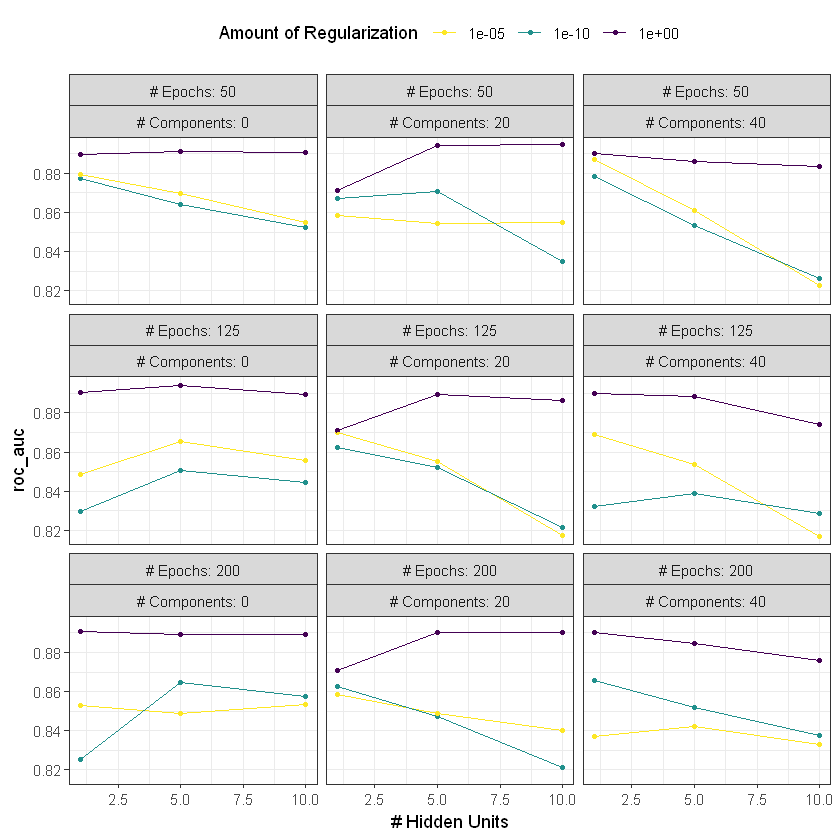

In [38]:
autoplot(mlp_reg_tune) + 
    scale_color_viridis_d(direction = -1) + 
    theme(legend.position = "top")

<br>

#### ```show_best()``` : 최적의 파라미터 조합 
- 높은 패널티 값을 통해, 더 큰 파라미터 값의 범위에서 그리드 서치를 다시 수행하는 것이 타당

In [39]:
show_best(mlp_reg_tune) %>% select(-.estimator)

hidden_units,penalty,epochs,num_comp,.metric,mean,n,std_err,.config
<int>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<chr>
10,1,50,20,roc_auc,0.8946776,10,0.010615745,Preprocessor2_Model09
5,1,50,20,roc_auc,0.8940653,10,0.009152942,Preprocessor2_Model08
5,1,125,0,roc_auc,0.8938269,10,0.007135379,Preprocessor1_Model17
5,1,50,0,roc_auc,0.8910566,10,0.011083689,Preprocessor1_Model08
1,1,200,0,roc_auc,0.8905355,10,0.007886059,Preprocessor1_Model25



- '공간 채우기 디자인'을 사용하기 위해 그리드 인수는 정수가 주어지거나 ```grid_*()``` 함수 중 하나가 데이터 프레임을 생성할 수 있음. 

<br>

#### 비정규 그리드
- 크기가 20인 '최대 엔트로피 디자인'

In [40]:
set.seed(1306)
mlp_sfd_tune <- mlp_wflow %>%
    tune_grid(cell_folds,    
              grid = 20, 
              param_info = mlp_param, 
              metrics = roc_res)

In [41]:
mlp_sfd_tune %>% print

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 × 4
   splits             id     .metrics          .notes          
   <list>             <chr>  <list>            <list>          
 1 <split [1817/202]> Fold01 <tibble [20 × 8]> <tibble [0 × 3]>
 2 <split [1817/202]> Fold02 <tibble [20 × 8]> <tibble [0 × 3]>
 3 <split [1817/202]> Fold03 <tibble [20 × 8]> <tibble [0 × 3]>
 4 <split [1817/202]> Fold04 <tibble [20 × 8]> <tibble [0 × 3]>
 5 <split [1817/202]> Fold05 <tibble [20 × 8]> <tibble [0 × 3]>
 6 <split [1817/202]> Fold06 <tibble [20 × 8]> <tibble [0 × 3]>
 7 <split [1817/202]> Fold07 <tibble [20 × 8]> <tibble [0 × 3]>
 8 <split [1817/202]> Fold08 <tibble [20 × 8]> <tibble [0 × 3]>
 9 <split [1817/202]> Fold09 <tibble [20 × 8]> <tibble [0 × 3]>
10 <split [1818/201]> Fold10 <tibble [20 × 8]> <tibble [0 × 3]>


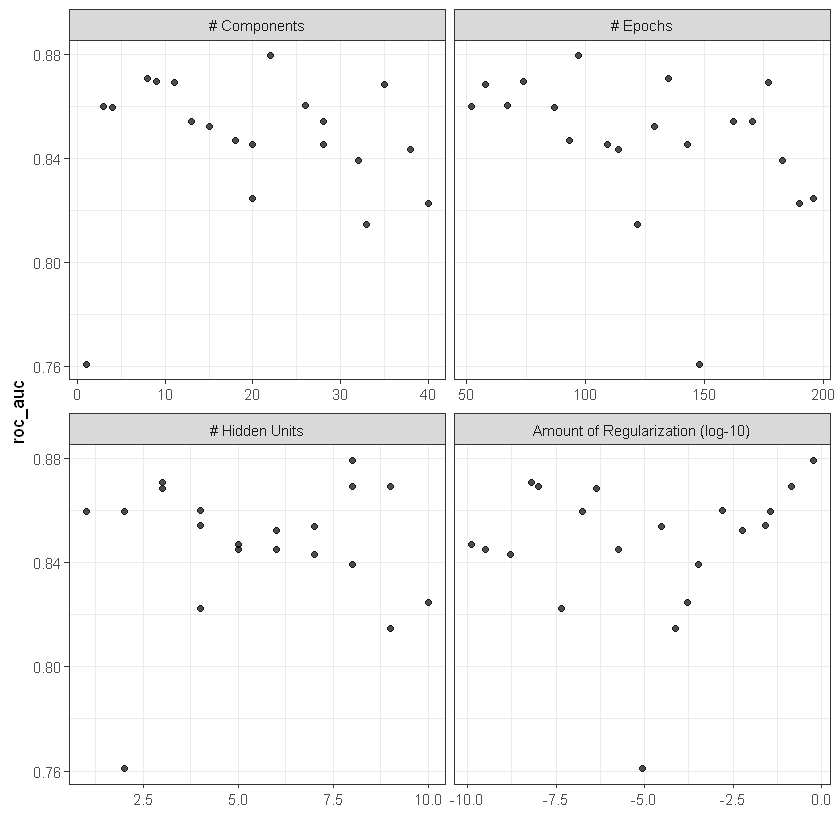

In [42]:
autoplot(mlp_sfd_tune)

- 패널티 파라미터는 더 낮은 값으로도 더 나은 성능을 제공하는 것으로 보임. 
    
    $\rightarrow$ **이는 정규 그리드의 결과와는 반대**
- **각 패널의 각 점은 다른 세 개의 튜닝 파라미터와 공유되므로, 한 패널의 추세는 다른 패널의 영향을 받을 수 있음**
- **정규 그리드를 사용하면 각 패널의 각 점이 다른 파라미터에 대해 동일하게 평균화 됨. 이러한 이유로, 각 파라미터의 효과는 정규 그리드로 더 잘 분리됨**

In [48]:
show_best(mlp_sfd_tune) %>% select(-.estimator) 

hidden_units,penalty,epochs,num_comp,.metric,mean,n,std_err,.config
<int>,<dbl>,<int>,<int>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,5.940130e-01,97,22,roc_auc,0.8804158,10,0.009984549,Preprocessor16_Model1
3,6.487197e-09,135,8,roc_auc,0.8784611,10,0.009551410,Preprocessor13_Model1
9,1.407762e-01,177,11,roc_auc,0.8727865,10,0.010380857,Preprocessor03_Model1
8,1.026357e-08,74,9,roc_auc,0.8693823,10,0.007608284,Preprocessor10_Model1
6,5.814140e-03,129,15,roc_auc,0.8650925,10,0.006581221,Preprocessor17_Model1


<br>

- **일반적으로 여러 모델 지표를 통하여 모형을 평가하고, 모형 적합의 다양한 측면이 고려되도록 하는 것이 바람직**
- 일반적으로 리샘플링과 파라미터 튜닝에서 중간 모델 적합을 유지하는 데에는 아무런 가치가 없음. 
    
- ```save_pred``` 옵션을 ```TRUE```로 설정하면 평가 세트 예측이 유지되며 ```collect_predictions()```를 사용하여 예측에 활용 가능

<br>

## 10.03 최종 모형 결정
- 최종 모형을 적합시키려면 최적 파라미터 조합을 결정 :
1. 적절한 것으로 보이는 값을 수동으로 선택
2. ```select_best()```등의 함수를 사용

<br>

#### ```select_best()``` : 수치적으로 가장 좋은 결과를 가진 파라미터를 선택

<br>

- AUC값 기준의 최적 파라미터

In [44]:
select_best(mlp_reg_tune, metric = "roc_auc")

hidden_units,penalty,epochs,num_comp,.config
<int>,<dbl>,<int>,<int>,<chr>
10,1,50,20,Preprocessor2_Model09


- 최적의 파라미터 채택

In [51]:
logistic_param <- tibble(num_comp = 0,
                         epochs = 50, 
                         hidden_units = 5,
                         penalty = 1)

- 최종 모형 정의

In [52]:
final_mlp_wflow <- mlp_wflow %>%
    finalize_workflow(logistic_param)

In [54]:
final_mlp_wflow

══ Workflow ════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: mlp()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_YeoJohnson()
• step_normalize()
• step_pca()
• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
Single Layer Neural Network Model Specification (classification)

Main Arguments:
  hidden_units = 5
  penalty = 1
  epochs = 50

Engine-Specific Arguments:
  trace = 0

Computational engine: nnet 


- 최종 모형 적합

In [55]:
final_mlp_fit <- final_mlp_wflow %>% fit(cells)

<br>

## 10.04 튜닝 사양 작성 도구 (`usemodels`)
- **`usemodels` 패키지는 데이터프레임과 모델 공식을 가져온 다음, 모델 튜닝을 위한 R코드를 생성**
- **코드는 요청된 모델과 예측 데이터에 따라 단계가 달라지는 적절한 레시피를 생성**

<br>

- `xgboost` 모델링



In [56]:
library(usemodels)

In [57]:
data(ames)
ames <- mutate(ames, Sale_Price = log10(Sale_Price))

In [58]:
set.seed(502)
ames_split <- initial_split(ames, prop = 0.80, strata = Sale_Price)
ames_train <- training(ames_split)
ames_test  <-  testing(ames_split)

In [59]:
use_xgboost(Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude, 
            data = ames_train,
            verbose = TRUE)

xgboost_recipe <- 
  recipe(formula = Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
    Latitude + Longitude, data = ames_train) %>% 
  step_zv(all_predictors()) 

xgboost_spec <- 
  boost_tree(trees = tune(), min_n = tune(), tree_depth = tune(), learn_rate = tune(), 
    loss_reduction = tune(), sample_size = tune()) %>% 
  set_mode("classification") %>% 
  set_engine("xgboost") 

xgboost_workflow <- 
  workflow() %>% 
  add_recipe(xgboost_recipe) %>% 
  add_model(xgboost_spec) 

set.seed(7019)
xgboost_tune <-
  tune_grid(xgboost_workflow, resamples = stop("add your rsample object"), grid = stop("add number of candidate points"))



- **`usemodels`의 결과로 나온 코드는, 모델링을 위해 필요한 최소한의 전처리**
    - `tune`을 `FALSE`로 입력시, 파라미터 튜닝이 없는 모델링 작성 코드 생성

In [60]:
use_xgboost(tune = F, Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + Latitude + Longitude, 
            data = ames_train,
            verbose = TRUE)

xgboost_recipe <- 
  recipe(formula = Sale_Price ~ Neighborhood + Gr_Liv_Area + Year_Built + Bldg_Type + 
    Latitude + Longitude, data = ames_train) %>% 
  step_zv(all_predictors()) 

xgboost_spec <- 
  boost_tree() %>% 
  set_mode("classification") %>% 
  set_engine("xgboost") 

xgboost_workflow <- 
  workflow() %>% 
  add_recipe(xgboost_recipe) %>% 
  add_model(xgboost_spec) 



<br>

## 10.0 효율적인 그리드 서치

### 하위 모델 최적화

**단일 모델 적합에서, 적합하지 않고도 여러 튜닝 파라미터를 평가할 수 있는 모델 유형이 존재**

<br>

1. PLS
- 부분 최소 제곱(PLS)은 주성분 분석의 지도학습 버전
- 설명변수(예: PCA)의 변동을 최대화하는 성분을 생성하며, 설명변수와 결과 간의 상관 관계를 최대화하려고 시도
- 한 가지 조정 매개 변수는 유지할 PLS 구성 요소의 수
- 설명변수가 100개인 데이터 집합이 PLS를 사용하여 적합하다고 가정 :
    - 유지할 수 있는 구성 요소의 수는 1개에서 50개까지
    - 그러나 많은 구현에서 단일 모델 적합은 `num_comp`의 많은 값에 걸쳐 예측 값을 계산할 수 있음. 
    - 결과적으로, 100개의 성분으로 생성된 PLS 모델은 또한 임의의 `num_comp` <= 100에 대한 예측을 할 수 있음. 
    - 중복 모형 적합치를 만드는 대신 단일 적합치를 사용하여 많은 하위 모형을 평가할 수 있으므로 시간이 절약

<br>

2. 부스팅
- 부스팅 모델은 일반적으로 부스팅 반복 횟수에 대한 여러 값에 걸쳐 예측을 할 수 있음. 

<br>

3. WLSE
- `glmnet` 모형과 같은 정규화 방법은 모형을 적합시키는 데 사용되는 정규화의 양에 걸쳐 동시 예측을 할 수 있음. 

<br>

4. MARS
- 다변량 적응 회귀 스플라인(MARS)은 선형 회귀 모형에 일련의 비선형 특징을 추가. 유지할 항 수는 튜닝 파라미터이며, 단일 모형 적합에서 이 파라미터의 많은 값에 걸쳐 예측하는 것이 계산적으로 빠름.



<br>

- **`tune` 패키지는 해당 모델이 튜닝될 때마다 이러한 유형의 최적화를 자동으로 적용**
    - 부스팅된 C5.0 분류 모델이 데이터에 적합했다면, 부스트 반복 횟수(트리)를 조정할 수 있음. 
- 다른 모든 파라미터를 기본값으로 설정하면, 이전에 사용한 것과 동일한 리샘플링에서 1부터 100까지의 반복을 평가할 수 있음


In [62]:
show_engines("boost_tree")

engine,mode
<chr>,<chr>
xgboost,classification
xgboost,regression
C5.0,classification
spark,classification
spark,regression


In [63]:
xgboost_spec <- boost_tree(trees = tune()) %>% 
    set_engine("xgboost") %>% 
    set_mode("classification")

In [64]:
set.seed(1307)
xgboost_spec %>% tune_grid(class ~ .,
                           resamples = cell_folds,
                           grid = data.frame(trees = 1:100),
                           metrics = roc_res) %>% print

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 × 4
   splits             id     .metrics           .notes          
   <list>             <chr>  <list>             <list>          
 1 <split [1817/202]> Fold01 <tibble [100 × 5]> <tibble [0 × 3]>
 2 <split [1817/202]> Fold02 <tibble [100 × 5]> <tibble [0 × 3]>
 3 <split [1817/202]> Fold03 <tibble [100 × 5]> <tibble [0 × 3]>
 4 <split [1817/202]> Fold04 <tibble [100 × 5]> <tibble [0 × 3]>
 5 <split [1817/202]> Fold05 <tibble [100 × 5]> <tibble [0 × 3]>
 6 <split [1817/202]> Fold06 <tibble [100 × 5]> <tibble [0 × 3]>
 7 <split [1817/202]> Fold07 <tibble [100 × 5]> <tibble [0 × 3]>
 8 <split [1817/202]> Fold08 <tibble [100 × 5]> <tibble [0 × 3]>
 9 <split [1817/202]> Fold09 <tibble [100 × 5]> <tibble [0 × 3]>
10 <split [1818/201]> Fold10 <tibble [100 × 5]> <tibble [0 × 3]>


<br>

### Racing Method
- **그리드 서치의 한 가지 문제는 튜닝 파라미터를 평가하기 전에, 모든 모델이 모든 리샘플링에 적합해야 한다는 것** 

    $\rightarrow$ 튜닝 중 어느 시점에서, 파라미터 후보를 제거하기 위해 중간 분석을 수행할 수 있다면 계산 속도가 향상

<br>

- **머신 러닝에서, Racing Method라고 불리는 일련의 기술은, 튜닝 프로세스중 리샘플링의 초기 하위 집합에 대해 모든 모델을 평가 후,**

    **성능 지표에 따라 일부 파라미터 집합은 후속 리샘플링에서 고려되지 않음**

<br>

#### 20개의 파라미터 튜닝과, 10개의 리샘플에 대한 Racing Method
- **모델의 결과는 단측 95% 신뢰 구간으로, 현재 가장 우수한 성능을 발휘하는 매개변수에 상대적인 ROC 값의 손실을 측정**


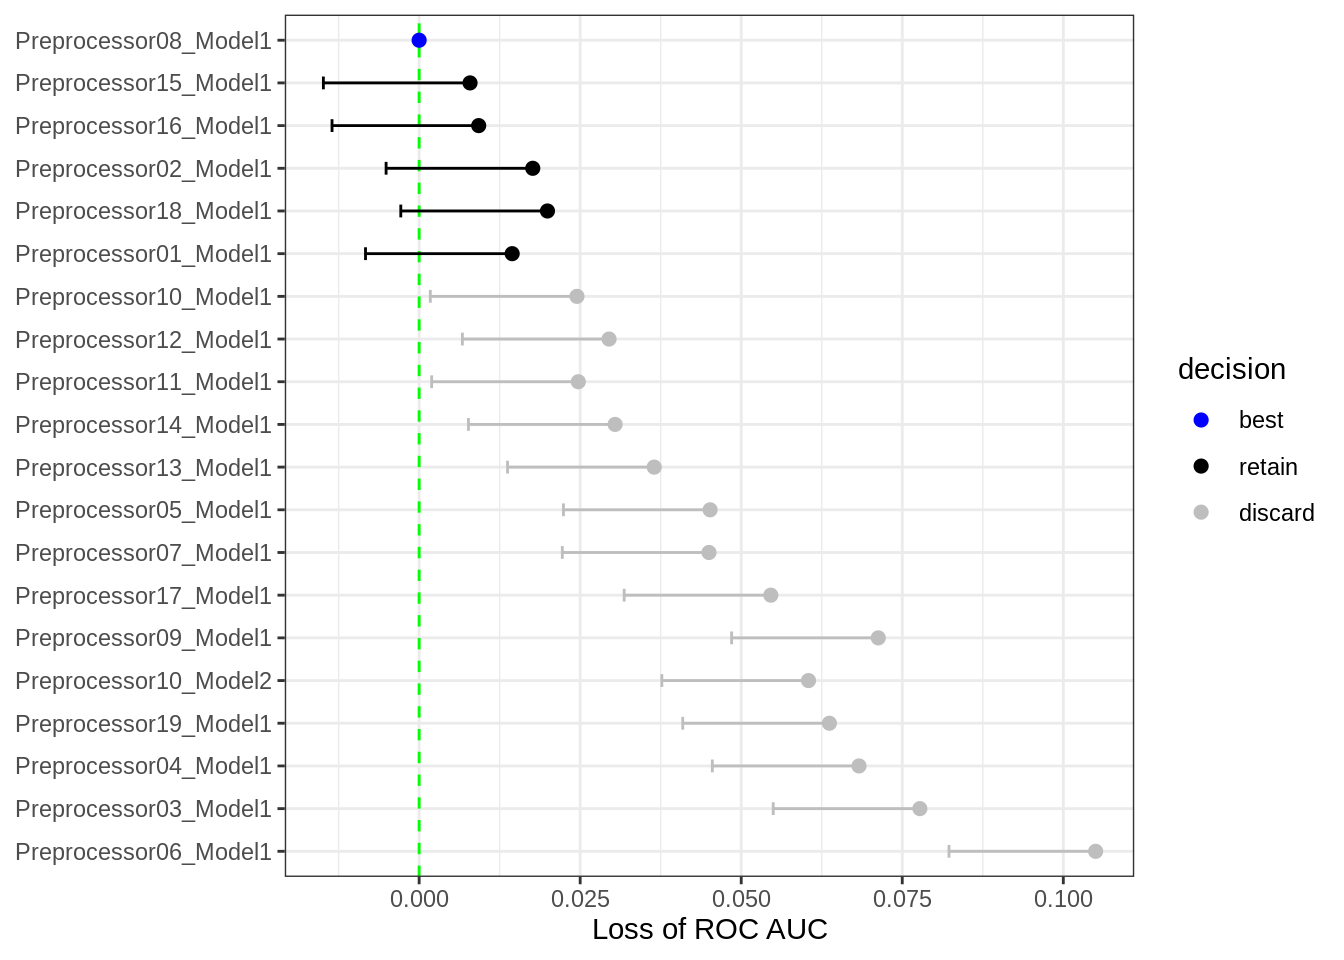


<br>


https://www.tmwr.org/race_results.mp4






#### ```tune_race_anova()``` : 분산 분석 모형을 수행하여 서로 다른 모형 구성의 통계적 유의성을 검정
- 인수들은 ```tune_grid()```의 인수들과 유사

- ```control_race()``` 함수에는 제거 절차에 대한 옵션이 존재

 

In [72]:
library(finetune)

In [73]:
set.seed(1308)
mlp_sfd_race <- mlp_wflow %>%
    tune_race_anova(cell_folds,
                    grid = 20,
                    param_info = mlp_param,
                    metrics = roc_res, 
                    control = control_race(verbose_elim = TRUE))

ℹ Racing will maximize the roc_auc metric.
ℹ Resamples are analyzed in a random order.
ℹ Fold10: 11 eliminated; 9 candidates remain.

ℹ Fold06: 1 eliminated; 8 candidates remain.

ℹ Fold08: 1 eliminated; 7 candidates remain.

ℹ Fold09: 0 eliminated; 7 candidates remain.

ℹ Fold05: 0 eliminated; 7 candidates remain.

ℹ Fold01: 1 eliminated; 6 candidates remain.

ℹ Fold07: 2 eliminated; 4 candidates remain.



In [74]:
print(mlp_sfd_race)

# Tuning results
# 10-fold cross-validation 
# A tibble: 10 × 5
   splits             id     .order .metrics          .notes          
   <list>             <chr>   <int> <list>            <list>          
 1 <split [1817/202]> Fold02      2 <tibble [20 × 8]> <tibble [0 × 3]>
 2 <split [1817/202]> Fold04      3 <tibble [20 × 8]> <tibble [0 × 3]>
 3 <split [1818/201]> Fold10      1 <tibble [20 × 8]> <tibble [0 × 3]>
 4 <split [1817/202]> Fold06      4 <tibble [9 × 8]>  <tibble [0 × 3]>
 5 <split [1817/202]> Fold08      5 <tibble [8 × 8]>  <tibble [0 × 3]>
 6 <split [1817/202]> Fold09      6 <tibble [7 × 8]>  <tibble [0 × 3]>
 7 <split [1817/202]> Fold05      7 <tibble [7 × 8]>  <tibble [0 × 3]>
 8 <split [1817/202]> Fold01      8 <tibble [7 × 8]>  <tibble [0 × 3]>
 9 <split [1817/202]> Fold07      9 <tibble [6 × 8]>  <tibble [0 × 3]>
10 <split [1817/202]> Fold03     10 <tibble [4 × 8]>  <tibble [0 × 3]>


In [75]:
show_best(mlp_sfd_race)

hidden_units,penalty,epochs,num_comp,.metric,.estimator,mean,n,std_err,.config
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,0.0401691390,151,10,roc_auc,binary,0.8859756,10,0.009198028,Preprocessor15_Model1
8,0.8139619097,177,15,roc_auc,binary,0.8843796,10,0.010246803,Preprocessor08_Model1
3,0.1229822435,55,36,roc_auc,binary,0.8786592,10,0.009293213,Preprocessor11_Model1
2,0.0007914545,164,7,roc_auc,binary,0.8784477,10,0.009084525,Preprocessor02_Model1
